In [1]:
%load_ext autotime

In [2]:
import os
from glob import glob

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('bmh')

from tqdm import tqdm_notebook

from piaa.utils import pipeline
from piaa.utils.postgres import get_cursor
from piaa.utils import helpers
from pocs.utils.images import fits as fits_utils
from pocs.utils.images import crop_data

from piaa.utils.postgres import get_cursor
tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

time: 29.6 s


In [3]:
fields_dir = os.path.join(os.environ['PANDIR'], 'images', 'fields')

time: 2.26 ms


In [4]:
base_dir = os.path.join(fields_dir, 'PAN001/Hd189733/14d3bd/20180913T085704')
# base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
# base_dir = '/var/panoptes/images/fields/PAN001/Tess_Sec05_Cam01/14d3bd/20181206T104750/'
# base_dir = os.path.join(fields_dir, 'PAN001/Wasp50/14d3bd/20181215T050712')
base_dir

'/var/panoptes/images/fields/PAN001/Hd189733/14d3bd/20180913T085704'

time: 18.2 ms


In [5]:
# Get all the files that start with a time stamp (skip pointing files)
fits_files = sorted(glob(
    os.path.join(base_dir, '*2018*.fits')
), )
print("Found {} FITS files".format(len(fits_files)))

Found 100 FITS files
time: 339 ms


## Lookup point sources

Looking up the point sources invovles two steps, extracting detected sources from the image and matching those with a catalog.

> Note: This assumes the images have already been downloaded and plate-solved.  
> _todo(wtgee) add a link to a notebook that does that_

**Source Detection** For source extraction there are three methods available but the default is to use the well-known [`sextractor`](https://www.astromatic.net/software/sextractor) to  automatically detect sources according to certain configurable parameters. The [PIAA sextractor config](https://raw.githubusercontent.com/panoptes/PIAA/develop/resources/conf_files/sextractor/panoptes.sex) sets a photometric aperture of 6 pixels ($6 \times 10.3'' \approx 80''$) and a detection threshold of 1.5 sigmas. Further filtering of flags and basic SNR is done below.

**Catalog Matching** PANOPTES hosts a copy of the TESS Input Catalog (v6) against which the detected sources are matched. The detection uses the peak pixel value as reported by `sextractor` compared against the TICv6 using standard [astropy catalog matching](http://docs.astropy.org/en/stable/coordinates/matchsep.html#matching-catalogs) techniques. Reported catalog separation is neglible, especially regarding the creationg of the stamps for the RGB pixel pattern (see below).

In [6]:
# Lookup the point sources
point_sources = pipeline.lookup_point_sources(
    fits_files[0], 
    force_new=True,
    cursor=tess_cursor,
)

# Display example
display(point_sources.head())
print(f'Sources extracted: {len(point_sources)}')

,ra,dec,x,y,x_image,y_image,background,flux_best,fluxerr_best,mag_best,...,flux_aper,fluxerr_aper,mag_aper,magerr_aper,flux_max,fwhm_image,flags,tmag,vmag,catalog_sep_arcsec
picid,,,,,,,,,,,,,,,,,,,,,
10668303,297.803310,29.901604,5147,1003,5146.8525,1003.3189,2066.695,457.4272,83.61388,18.3492,...,364.5027,57.93084,18.5957,0.1726,73.26900,2.74,0,12.270,12.949000,18.683905
10668414,297.794517,29.888950,5142,1001,5142.4092,1000.5766,2066.948,615.7108,96.37968,18.0266,...,513.1212,58.66777,18.2245,0.1242,91.00167,2.42,0,12.497,12.942000,19.586639
10668747,297.805810,29.868426,5135,1004,5135.0659,1003.9340,2066.861,2091.2230,90.49911,16.6990,...,1842.7120,65.85644,16.8364,0.0388,319.08130,7.49,0,11.807,16.014999,5.247506
10669263,297.871030,29.828000,5120,1024,5120.3848,1023.6815,2067.137,517.9924,84.50603,18.2142,...,416.8243,58.08033,18.4501,0.1513,80.79022,2.56,0,12.164,12.797000,15.368465
10669478,297.736648,29.805948,5113,983,5113.2705,982.5175,2065.540,1329.5300,101.01170,17.1908,...,959.5948,61.22357,17.5448,0.0693,228.43220,2.35,0,11.226,11.573000,15.167372


Sources extracted: 41750
time: 17.2 s


#### Lookup all files

Perform the same thing again but for all files. The resulting source catalog created from `sextractor` is saved for each image and reused in subsequent runs unless `force_new=True`.

Extract the observation time, the exposure time, and the airmass from the FITS headers.

The image observation time currently comes from the image file name, which is generated by the computer running the unit and is given in UTC. This is mainly due to a problem with the `DATE-OBS` header in the FITS files for POCS versions <0.6.2.

In [7]:
source_filename = os.path.join(base_dir, f'point-sources-detected.csv')

observation_sources = pipeline.lookup_sources_for_observation(
    fits_files=fits_files, 
    filename=source_filename, 
    cursor=tess_cursor, 
    force_new=True
)

 67%|██████▋   | 67/100 [18:15<09:35, 17.44s/it]

MemoryError: 

time: 18min 34s


In [8]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 80 Sources: 7829
time: 111 ms


## Filter detected sources

The above sequence does basic source filtering via `sextractor` along with what can be matched in the TESS catalog. Below are a number of different ways to filter the frames and/or sources based on image quality, number of detections, etc.

The filtering for the `PAN012` HD189733 data set involves the steps below. At the bottom of the notebook are optional filter methods.

#### Image filtering

We can do some quick checks on the overall image sequence. here we look at the mean background as detected by `sextractor`. It's a rough metric but we can clearly see some frames where the background levels spike, indicating clouds in the region.

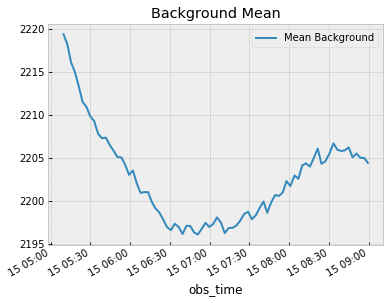

time: 1.93 s


In [9]:
plt.figure(figsize=(6, 4.5))
observation_sources.groupby('obs_time').background.mean().plot(label='Mean Background')
plt.title(f'Background Mean')
plt.legend()

#### Filter frames by number of detected sources

Here we remove frames where the total number of detected frames is outside of two standard deviations of the mean number of detected sources.

Usually this is due to clouds passing over, which causes the number of detected sources to drop dramatically across the entire frame.

We could have a smarter method of filtering these frames, e.g. by examining the FWHM of the stars.

In [38]:
num_sources = observation_sources.groupby('obs_time').count().file
min_sources = int(num_sources.mean() - (2 * num_sources.std()))
print(f'Frames should have at least {min_sources} sources')

Frames should have at least 4966 sources
time: 77.3 ms


In [39]:
observation_sources.groupby('obs_time').describe().head()

ra                                             \
                      count       mean       std        min        25%   
obs_time                                                                 
2018-12-15 05:09:49  5552.0  43.637419  2.814236  38.696393  41.213978   
2018-12-15 05:12:43  6160.0  43.628294  2.817929  38.696646  41.201012   
2018-12-15 05:15:31  6831.0  43.628780  2.816603  38.696027  41.195258   
2018-12-15 05:18:20  6057.0  43.656167  2.816269  38.696301  41.219586   
2018-12-15 05:21:13  5172.0  43.635214  2.815891  38.696397  41.219039   

                                                         dec             \
                           50%        75%        max   count       mean   
obs_time                                                                  
2018-12-15 05:09:49  43.610202  46.067342  48.641744  5552.0 -11.232656   
2018-12-15 05:12:43  43.593286  46.057641  48.641175  6160.0 -11.214582   
2018-12-15 05:15:31  43.617464  46.052988  48.640687  6831.0 -11.200642   
2018-12-15 05:18:20  43.658071  46.088734  48.641402  6057.0 -11.238649   
2018-12-15 05:21:13  43.606629  46.071194  48.620235  5172.0 -11.260123   

                         ...        airmass             picid                \
                         ...            75%       max   count          mean   
obs_time                 ...                                                  
2018-12-15 05:09:49      ...       1.505343  1.505343  5552.0  1.640488e+08   
2018-12-15 05:12:43      ...       1.489218  1.489218  6160.0  1.647132e+08   
2018-12-15 05:15:31      ...       1.474171  1.474171  6831.0  1.660143e+08   
2018-12-15 05:18:20      ...       1.459603  1.459603  6057.0  1.658148e+08   
2018-12-15 05:21:13      ...       1.445154  1.445154  5172.0  1.645014e+08   

                                                                       \
                              std        min          25%         50%   
obs_time                                                                
2018-12-15 05:09:49  1.792414e+08  4697337.0  30018215.25  66667750.5   
2018-12-15 05:12:43  1.817685e+08  4697337.0  30018362.50  66667544.0   
2018-12-15 05:15:31  1.822101e+08  4697279.0  30018662.00  66668292.0   
2018-12-15 05:18:20  1.809035e+08  4697337.0  30018677.00  66668540.0   
2018-12-15 05:21:13  1.815816e+08  4697337.0  30018641.75  66667829.0   

                                                 
                              75%           max  
obs_time                                         
2018-12-15 05:09:49  4.250782e+08  1.415066e+09  
2018-12-15 05:12:43  4.250784e+08  1.415066e+09  
2018-12-15 05:15:31  4.250787e+08  1.415066e+09  
2018-12-15 05:18:20  4.250789e+08  1.415066e+09  
2018-12-15 05:21:13  4.250780e+08  1.415066e+09  

[5 rows x 192 columns]

time: 5.45 s


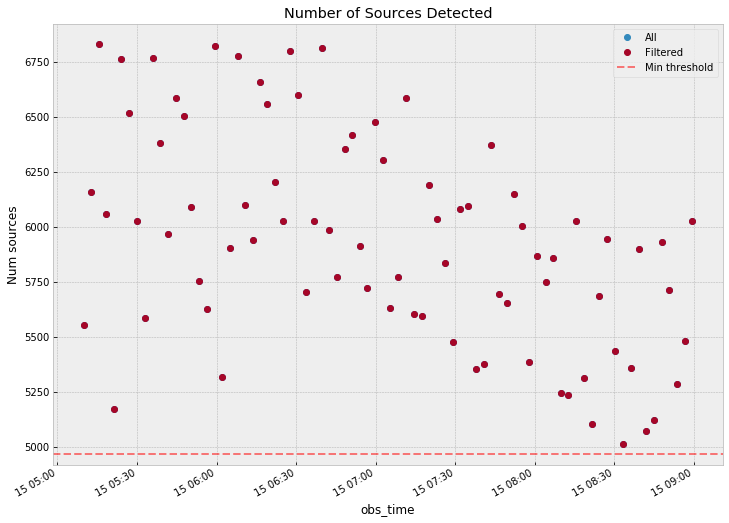

time: 1.15 s


In [40]:
plt.figure(figsize=(12, 9))
observation_sources.groupby('obs_time').count().picid.plot(marker='o', ls='', label='All')
observation_sources.groupby('obs_time').filter(
    lambda grp: grp.count().picid >= min_sources
).groupby('obs_time').count().file.plot(marker='o', ls='', label='Filtered')
plt.axhline(min_sources, c='r', alpha=0.5, ls='--', label='Min threshold')

plt.ylabel('Num sources')
plt.title('Number of Sources Detected')
plt.legend()

In [25]:
# Filter out the frames where the number of source detections is outside the std
observation_sources = observation_sources.groupby('obs_time').filter(lambda grp: grp.count()['file'] >= min_sources)

time: 3.4 s


In [26]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 86 Sources: 72722
time: 431 ms


#### Filter sources by number of frames

Now that we have removed frames where there were a low number of detections (presumably from clouds) we now want to remove sources that don't appear in most of the frames.

In [27]:
frame_count = observation_sources.groupby('picid').count().file
min_frame_count = int(frame_count.max() * .9)

print(f'Total frames: {frame_count.max()} Min cutout: {min_frame_count}')

Total frames: 86 Min cutout: 77
time: 1.01 s


Text(0.5, 1.0, 'Total number of frames')

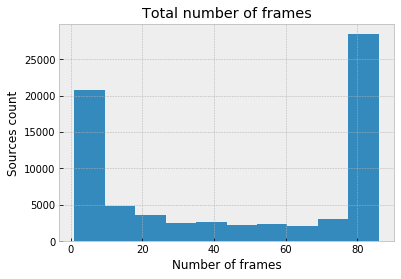

time: 324 ms


In [28]:
# Show a sample of the source count
frame_count.hist()
plt.xlabel('Number of frames')
plt.ylabel('Sources count')
plt.title('Total number of frames')

In [29]:
# Filter out the sources where the number of frames is less than min_frame_count
observation_sources = observation_sources.groupby('picid').filter(lambda grp: grp.count()['file'] >= min_frame_count)

time: 1min 22s


In [30]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 86 Sources: 28826
time: 278 ms


#### Filter frames by manual time-clipping

For now we are going to simply manually remove the frames after a certain time that was visually identified with cloud cover.

In [ ]:
observation_sources = observation_sources.loc[observation_sources.index.levels[1] < '2018-08-22 07:10:00']

#### Filter frames by Sigma-clip

We can sigma clip the frames based on the mean background value, removing any frame that deviate wildly from the rest of the sequence.

In [ ]:
back_mean, back_median, back_std = sigma_clipped_stats(image_group.background.mean())

observation_sources = observation_sources.groupby('obs_time').filter(lambda grp: np.abs(grp['background'].mean() - back_mean) <= 3 * back_std )

num_frames = len(observation_sources.index.unique())

In [ ]:
num_frames = len(observation_sources.index.levels[1].unique())
num_sources = len(observation_sources.index.levels[0].unique())
print(f"Frames: {num_frames} Sources: {num_sources}")

In [ ]:
plt.figure(figsize=(6, 4.5))
plt.plot(observation_sources.groupby('obs_time').background.mean().values, label='Mean Background')
plt.title(f'Background Mean')
plt.legend()

#### Source filtering

`sextractor` does basic thresholding and source detection per frame but here we filter sources based off the entire image sequence. The simplest filter is to get all the images with a certain SNR limit (default 10). A filter for source extractor flags can also be used.

> Note: There has been a manual selection of images (see above) for overall data quality. Some kind of image quality check (e.g. drifting zeropoint) could help automate this

In [31]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 86 Sources: 28826
time: 298 ms


#### sextractor flags filter

Filter out anything with [SE flags](http://matilda.physics.ucdavis.edu/working/website/SEflags.html) of 4 or more. Note that this is leaving in some blended sources 

In [32]:
observation_sources = observation_sources.groupby('picid').filter(lambda grp: all(grp['flags'] < 4))

time: 15 s


In [33]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 86 Sources: 28653
time: 264 ms


##### SNR Filter

The SNR comes directly from `sextractor` in the form of `FLUX_AUTO / FLUXERR_AUTO`.

In [ ]:
snr_limit = 10

observation_sources = observation_sources.groupby('picid').filter(lambda grp: grp['snr'].mean() > snr_limit)

In [35]:
num_frames = len(observation_sources.index.unique())
num_sources = len(set(observation_sources.picid))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 86 Sources: 28653
time: 287 ms


#### Output filtered source detections

We save this filtered file to be used for subsequent processing.

In [51]:
filtered_filename = os.path.join(base_dir, f'point-sources-filtered.csv.bz2')

time: 907 µs


In [52]:
observation_sources.to_csv(filtered_filename, compression='bz2')

time: 2min 32s


In [53]:
ls -lh $filtered_filename

-rw-r--r-- 1 wtylergee wtylergee 172M Oct 30 02:32 /var/panoptes/images/fields/PAN001/Hd189733/14d3bd/20180913T085704/point-sources-filtered.csv.bz2
time: 180 ms
